In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
patients_df = pd.read_csv('data/adhd_data2.csv')
patients_df[::]

,subject_id,gender,drug,hallucinations,ocd,adhd_only
0,303,True,Hydromorphone,False,False,True
48,715,False,DiphenhydrAMINE,False,True,False
99,1590,True,Morphine Sulfate IR,False,False,True
216,2945,False,Olanzapine,True,True,False
238,2170,True,Potassium Chloride,False,False,True
...,...,...,...,...,...,...
18141,94075,True,Famotidine,False,False,True
18176,97974,False,Ritonavir (Oral Solution),False,False,True
18321,96463,True,Propofol,True,False,False
18339,98177,True,0.9% Sodium Chloride,False,False,True


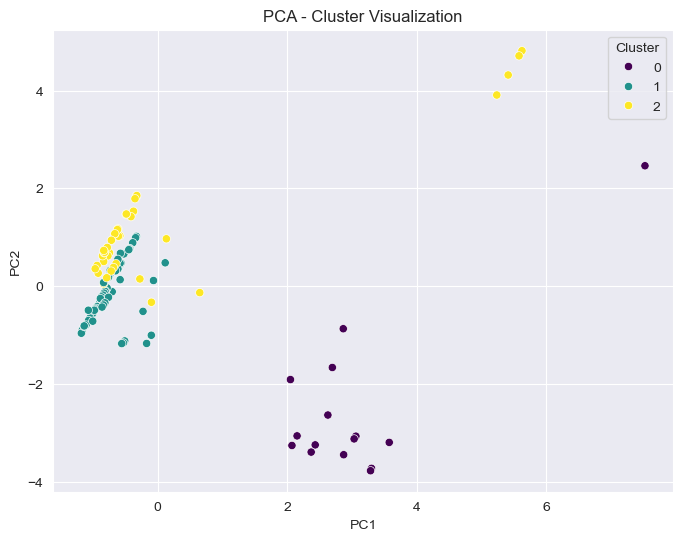

In [4]:
# Use PCA to reduce the dimensionality of the data and then plot the clusters

# Preprocess data to numbers
data_encoded = pd.get_dummies(patients_df, ["drug"])

scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_encoded)

kmeans = KMeans(n_clusters=3, random_state=30, n_init=10)
data_encoded['cluster'] = kmeans.fit_predict(df_scaled)

# Reduce to 2 principal components
pca = PCA(n_components=2)

df_pca = pca.fit_transform(df_scaled)

# Convert to DataFrame
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = kmeans.labels_

# Scatter plot of clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Cluster", palette="viridis")
plt.title("PCA - Cluster Visualization")
plt.show()

In [5]:
# Figure out what each cluster represents
print(data_encoded["cluster"].value_counts())

cluster_summary = data_encoded.groupby("cluster").mean()

pd.crosstab(patients_df["drug"], data_encoded["cluster"])

cluster
1    66
2    39
0    15
Name: count, dtype: int64


cluster,0,1,2
drug,,,
0.9% Sodium Chloride,1,7,4
1/2 NS,1,2,0
5% Dextrose,0,1,1
Acetaminophen,0,0,1
Acyclovir,0,1,0
...,...,...,...
Thiamine,1,0,0
Vancomycin,0,1,0
Vancomycin HCl,0,1,0


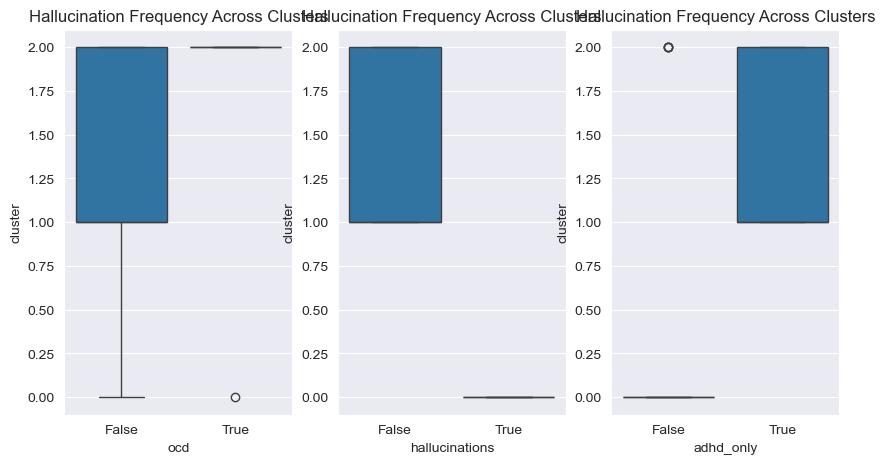

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
sns.boxplot(x="ocd", y="cluster", data=data_encoded)
plt.title("Hallucination Frequency Across Clusters")
plt.subplot(1,3,2)
sns.boxplot(x="hallucinations", y="cluster", data=data_encoded)
plt.title("Hallucination Frequency Across Clusters")
plt.subplot(1,3,3)
sns.boxplot(x="adhd_only", y="cluster", data=data_encoded)
plt.title("Hallucination Frequency Across Clusters")
plt.show()

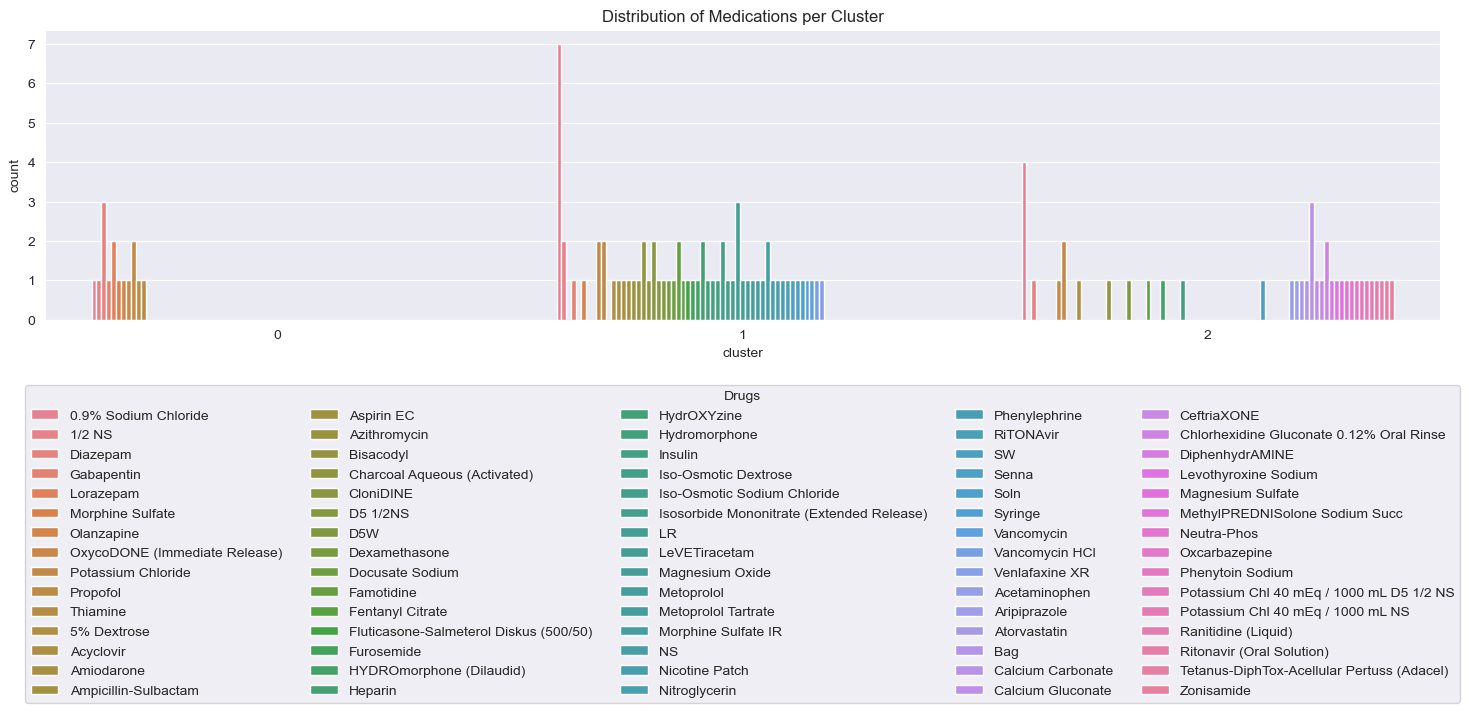

In [7]:
# decode drugs & plot them
drug_col = [col for col in data_encoded.columns if col.startswith("drug_")]
data_melted = pd.melt(data_encoded, id_vars="cluster", value_vars=drug_col, var_name="drug", value_name="presence")
data_melted = data_melted[data_melted["presence"] == 1]
data_melted["drug"] = data_melted["drug"].str.replace("drug_", "")

plt.figure(figsize=(18,5))
sns.countplot(x="cluster", hue="drug", data=data_melted)
# sns.countplot(x="drug", hue="cluster", data=data_melted)
plt.title("Distribution of Medications per Cluster")

plt.legend(title="Drugs", bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=5)
plt.subplots_adjust(bottom=0.3)
plt.show()

In [8]:
# Get the correct number of features
feature_columns = data_encoded.drop(columns="cluster").columns  # Use actual feature names after encoding

pca_components = pd.DataFrame(
    pca.components_,
    columns=feature_columns,  # Use actual feature names
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Show features that contribute most to PC1 and PC2
print("Top Features in PC1:")
print(pca_components.T.sort_values(by="PC1", ascending=False).head(10))

print("\nTop Features in PC2:")
print(pca_components.T.sort_values(by="PC2", ascending=False).head(10))

Top Features in PC1:
                               PC1       PC2
ocd                       0.432633  0.372694
hallucinations            0.408746 -0.422418
drug_Olanzapine           0.243560  0.099788
drug_DiphenhydrAMINE      0.182091  0.195138
drug_Phenytoin Sodium     0.180636  0.190888
drug_Ranitidine (Liquid)  0.175200  0.175017
drug_Oxcarbazepine        0.169512  0.158411
drug_Lorazepam            0.157781 -0.200614
drug_Diazepam             0.157702 -0.200582
drug_Thiamine             0.106902 -0.151025

Top Features in PC2:
                                                    PC1       PC2
ocd                                            0.432633  0.372694
adhd_only                                     -0.546469  0.203529
drug_DiphenhydrAMINE                           0.182091  0.195138
drug_Phenytoin Sodium                          0.180636  0.190888
drug_Ranitidine (Liquid)                       0.175200  0.175017
drug_Oxcarbazepine                             0.169512  0.158411


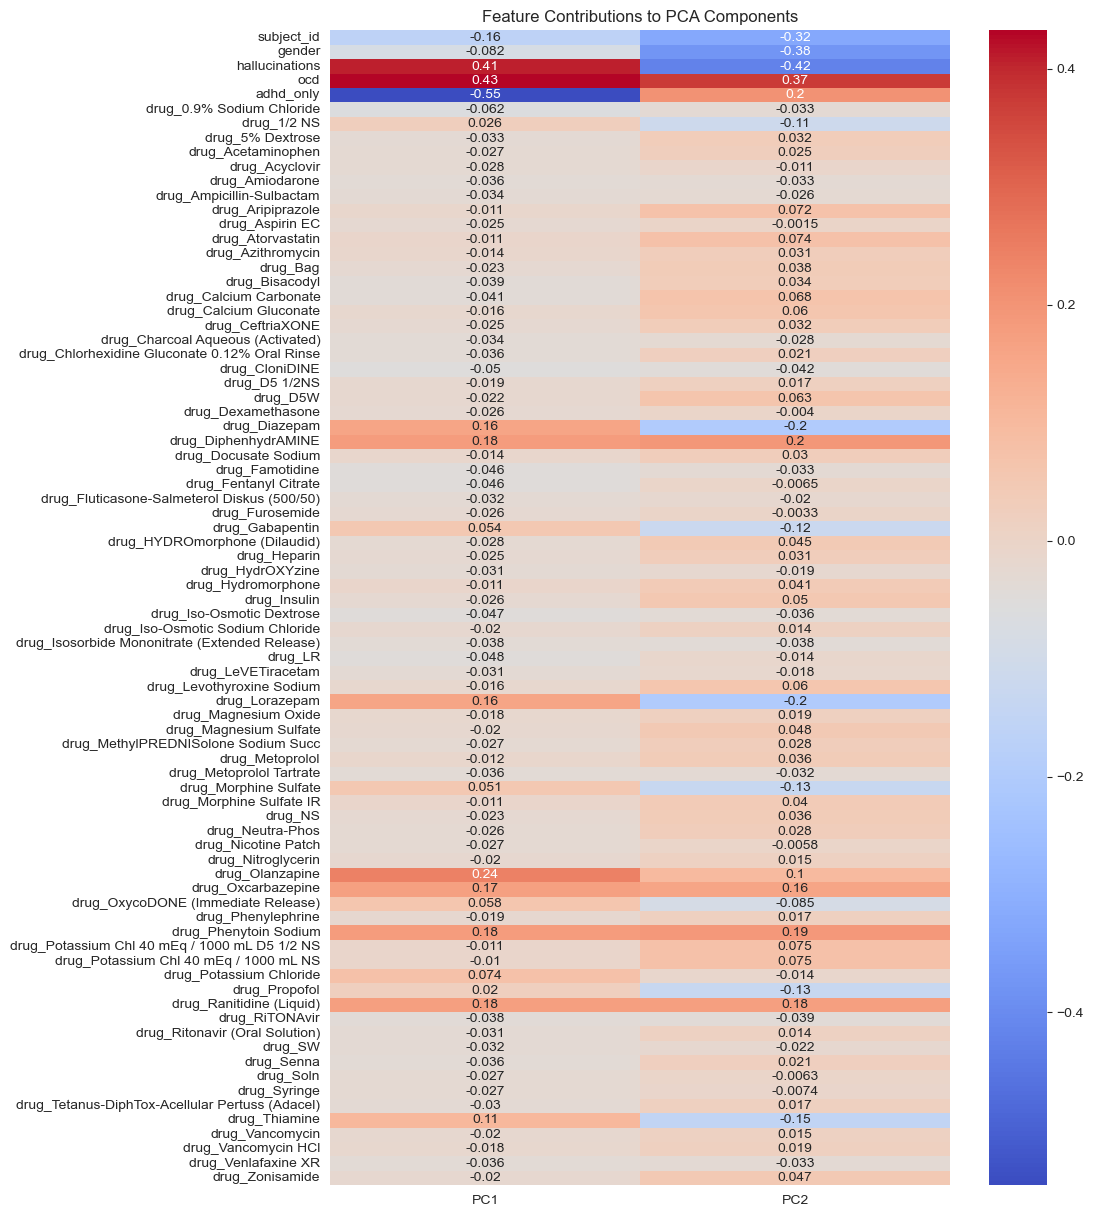

In [9]:
plt.figure(figsize=(10,15))
sns.heatmap(pca_components.T, annot=True, cmap="coolwarm")
plt.title("Feature Contributions to PCA Components")
plt.show()